In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import jax
import jax.numpy as jnp
import numpy as np
from stljax.formula import *
from stljax.viz import *
import matplotlib.pyplot as plt
import equinox as eqx
from typing import Callable
from jax import random

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from stljax.utils import smooth_mask, anneal


from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

/Users/karen/venvs/test/lib/python3.12/site-packages/equinox/internal/_noinline.py:379: DeprecationWarning: jax.core.pp_eqn_rules is deprecated.
  jax.core.pp_eqn_rules[noinline_p] = _noinline_pretty_print


In [3]:
def test_grad(signal, temperature, approx_method):
    signal_flip = jnp.flip(signal)
    m = lambda x: maxish(x, axis=axis, keepdims=keepdims, approx_method=approx_method, temperature=temperature)
    # s0 = jnp.array([signal[0]])
    s0 = jnp.zeros(0)
    for s in signal_flip:
        s0 = m(jnp.concat([s0, jnp.array([s])]))
    return s0.squeeze() 

In [28]:
# analyzing gradients
interval = None
pred = Predicate('x', lambda x: x)
rec = EventuallyRecurrent((pred > 0.), interval=interval)
ev = Eventually((pred > 0.), interval=interval)


In [29]:
T = 10
signal = jnp.arange(T) * 1.
signal_flip = jnp.flip(signal)


In [30]:
approx_method = "logsumexp"
temperature = 0.1
axis = 0
keepdims = True
large_number = None

In [31]:
interval = [5, jnp.inf]
until_rec = UntilRecurrent(pred > -5., pred < 6, interval=interval)
until_mask = Until(pred > -5., pred < 6, interval=interval)

until_mask.robustness(signal, padding=large_number, approx_method=approx_method, temperature=temperature), until_rec.robustness(signal_flip, padding=large_number, approx_method=approx_method, temperature=temperature)


(Array(0.9946346, dtype=float32), Array(0.9946358, dtype=float32))

In [32]:

mask_grads = jax.grad(until_mask.robustness)(signal, approx_method=approx_method, temperature=temperature)
# test_grads = jax.grad(test_grad)(signal, temperature, approx_method)
rec_grads = jnp.flip(jax.grad(until_rec.robustness)(signal_flip, approx_method=approx_method, temperature=temperature))

mask_grads, rec_grads


(Array([ 0.13611487,  0.12316183,  0.11144143,  0.10083637,  0.09124053,
         0.02524319,  0.00250334, -0.0138594 , -0.02578233, -0.03452376],      dtype=float32),
 Array([ 0.13611487,  0.12316182,  0.11144143,  0.10083638,  0.09124053,
         0.02524318,  0.00250334, -0.01385939, -0.02578233, -0.03452376],      dtype=float32))

In [33]:

mask_grads = jax.grad(ev.robustness)(signal, padding=large_number, approx_method=approx_method, temperature=temperature)
# test_grads = jax.grad(test_grad)(signal, temperature, approx_method)
rec_grads = jnp.flip(jax.grad(rec.robustness)(signal_flip, padding=large_number, approx_method=approx_method, temperature=temperature))

mask_grads, rec_grads


(Array([0.06120703, 0.06764423, 0.07475843, 0.08262085, 0.09131017,
        0.10091334, 0.11152648, 0.12325581, 0.13621874, 0.150545  ],      dtype=float32),
 Array([0.06120701, 0.06764421, 0.07475844, 0.08262084, 0.09131014,
        0.10091332, 0.11152645, 0.1232558 , 0.13621873, 0.15054499],      dtype=float32, weak_type=True))

In [37]:
# analyzing gradients
interval = [4, 8]
pred = Predicate('x', lambda x: x)
phi = pred > -5.
psi = pred < 6.
# rec = EventuallyRecurrent(AlwaysRecurrent(phi), interval=interval)
# mask = Eventually(Always(phi), interval=interval)

rec = UntilRecurrent(AlwaysRecurrent(phi), EventuallyRecurrent(psi), interval=interval)
mask = Until(Always(phi), Eventually(psi), interval=interval)


In [38]:
T = 10
signal = jnp.arange(T) * 1.
signal_flip = jnp.flip(signal)


In [39]:
temperature = 10.
approx_method = "logsumexp"

In [40]:
mask(signal, approx_method=approx_method, temperature=temperature) - jnp.flip(rec(signal_flip, approx_method=approx_method, temperature=temperature))

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [41]:
jax.grad(mask.robustness)(signal, approx_method=approx_method, temperature=temperature) 

Array([ 9.3576297e-14,  8.4967149e-18,  5.7862536e-22,  3.5026071e-26,
       -9.9990928e-01, -9.0791647e-05, -6.1829017e-09, -3.7427109e-13,
       -2.1239851e-17, -9.6428782e-22], dtype=float32)

In [42]:
jnp.flip(jax.grad(rec.robustness)(signal_flip, approx_method=approx_method, temperature=temperature))

Array([ 9.3576344e-14,  8.4967182e-18,  5.7862556e-22,  3.5026074e-26,
       -9.9990928e-01, -9.0791655e-05, -6.1829040e-09, -3.7427131e-13,
       -2.1239867e-17, -9.6428853e-22], dtype=float32, weak_type=True)

In [18]:
def plot_gradients(temperature, approx_method):
    mask_grads = jax.grad(ev.robustness)(signal, padding=large_number, approx_method=approx_method, temperature=temperature)
    rec_grads = jnp.flip(jax.grad(rec.robustness)(signal_flip, padding=large_number, approx_method=approx_method, temperature=temperature))
    # rec_grads = jax.grad(test_grad)(signal, temperature, approx_method)
    # rec_grads = jax.grad(rec_robustness)(signal, approx_method=approx_method, temperature=temperature, padding=1E9)
    plt.bar(jnp.arange(T)-0.125, mask_grads, label="Mask", width=0.22, alpha=0.5)
    plt.bar(jnp.arange(T)+0.124, rec_grads, label="Rec.", width=0.22, alpha=0.5)
    height = max(mask_grads.max(), rec_grads.max())
    plt.vlines(jnp.argmax(signal), 0, height, zorder=-5, linestyle='--', label='True max')
    # plt.ylim([-0.2, 1.2])
    plt.grid()
    plt.title("$\\tau$ = %.2f"%temp)


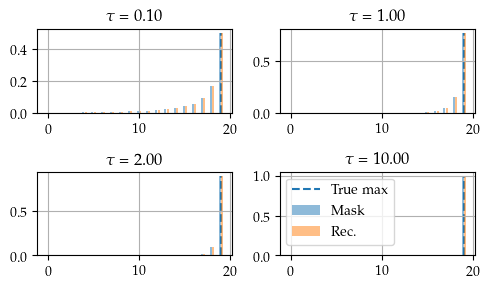

In [19]:
plt.figure(figsize=(5,3))
for (i, temp) in enumerate([0.1, 1., 2., 10.]):
    plt.subplot(2,2,i+1)
    plot_gradients(temp, approx_method)

plt.legend(loc="upper left")
plt.tight_layout()
# plt.savefig("figs/softmax_gradients.png", dpi=200, transparent=True)

In [20]:
temp_slider = widgets.FloatSlider(value=1., min=0.1, max=5., step=0.1, description='temperature:')
approx_method_slider = widgets.Dropdown(
    options=['true', "logsumexp", "softmax"],
    value='true',
    description='approx method:',
    disabled=False,
)
interact(plot_gradients, temperature=temp_slider, approx_method=approx_method_slider)


/Users/karen/venvs/test/lib/python3.12/site-packages/ipywidgets/widgets/interaction.py:43: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  from ipykernel.pylab.backend_inline import flush_figures


interactive(children=(FloatSlider(value=1.0, description='temperature:', max=5.0, min=0.1), Dropdown(descripti…

<function __main__.plot_gradients(temperature, approx_method)>